# from UTM to lat,lon

# Map with ellipses

In [1]:
from pyrocko import util, model, io, trace, moment_tensor, gmtpy,orthodrome
from pyrocko import orthodrome as od
from pyrocko.client import catalog
from pyrocko.automap import Map
import pyrocko.moment_tensor as pmt
from pyrocko.plot import mpl_color
from pyrocko.guts import load
# from seiscloud import plot as scp
# from seiscloud import cluster as scc
import numpy as np
import os
# import shutil
import matplotlib.pyplot as plt
import pygmt

In [4]:
workdir='../../clusty_flegrei/'
switch_VT=False               # CHANGE

if switch_VT:
    catdir=os.path.join(workdir,'results_VT')
else: 
    catdir=os.path.join(workdir,'results_VLP')
catname=os.path.join(catdir,'cat_trimmed_mean_ccs_dbscan_comb_0.150_3.yaml')               # CHANGE

clusty_events=model.load_events(catname,format='yaml')


In [5]:
cluster_number=[]
cluster_color=[]
for ev in clusty_events:
    if not ev.extras['cluster_number'] in cluster_number:
        cluster_number.append(ev.extras['cluster_number'])
        cluster_color.append(ev)

cls = {key: [] for key in cluster_number}
for ev in clusty_events:
    cls[ev.extras['cluster_number']].append(ev)

cls_color = {key: [] for key in cluster_number}
for color in cluster_color:
    cls_color[color.extras['cluster_number']].append(color.extras['color'])

if switch_VT:
    del cls[-1]     #remove ev not clustered, only for VT
    del cls_color[-1]

for key in cls:
    print(f'cluster {key} with n ev = {len(cls[key])}')
    print(f'cluster {key} with color {cls_color[key]}\n')

cluster 0 with n ev = 12
cluster 0 with color ['#00A08B']



In [6]:
cls_lat_mean    =[]
cls_lon_mean    =[]
cls_depth_mean  =[]
cls_mag_mean    =[]
cls_lat_std     =[]
cls_lon_std     =[]
cls_depth_std   =[]
cls_mag_std     =[]
cls_lat_all     =[]
cls_lon_all     =[]
cls_max_mag     =[]

for key in cls:
    lat=[]
    lon=[]
    depth=[]
    mag=[]

    for ev in cls[key]:
        lat.append(ev.lat)
        lon.append(ev.lon)
        depth.append(ev.depth)
        mag.append(ev.magnitude)

    lat_mean=np.mean(lat)
    lat_std=np.std(lat)
    
    lon_mean=np.mean(lon)
    lon_std=np.std(lon)
    
    depth_mean=np.mean(depth)
    depth_std=np.std(depth)

    mag_mean=np.mean(mag)
    mag_std=np.std(mag)
    max_mag=np.max(mag)

    cls_lat_all.append(np.array(lat))
    cls_lon_all.append(np.array(lon))
 
    cls_lat_mean.append(lat_mean)
    cls_lon_mean.append(lon_mean)
    cls_depth_mean.append(depth_mean)
    cls_mag_mean.append(mag_mean)
    cls_max_mag.append(max_mag)

    cls_lat_std.append(lat_std)
    cls_lon_std.append(lon_std)
    cls_depth_std.append(depth_std)
    cls_mag_std.append(mag_std)

cls_lat_mean    =np.array(cls_lat_mean    )
cls_lon_mean    =np.array(cls_lon_mean    )
cls_depth_mean  =np.array(cls_depth_mean  )
cls_mag_mean    =np.array(cls_mag_mean    )
cls_lat_std     =np.array(cls_lat_std     )
cls_lon_std     =np.array(cls_lon_std     )
cls_depth_std   =np.array(cls_depth_std   )
cls_mag_std     =np.array(cls_mag_std     )

In [7]:
for i,key in enumerate(cls):
    print(f'cluster {key} mean depth: \t\t{cls_depth_mean[i]:4.0f} +- {cls_depth_std[i]:4.0f}')
    print(f'cluster {key} mean magnitude: \t{cls_mag_mean[i]:2.2f} +- {cls_mag_std[i]:2.2f}')
    print(f'cluster {key} max magnitude: \t{cls_max_mag[i]:2.3f}')
    print(f'cluster {key} mean lat:  \t\t{cls_lat_mean[i]:2.5f} +- {cls_lat_std[i]:2.5f}')
    print(f'cluster {key} mean lon:  \t\t{cls_lon_mean[i]:2.5f} +- {cls_lon_std[i]:2.5f}\n')

cluster 0 mean depth: 		3634 +-  604
cluster 0 mean magnitude: 	1.95 +- 0.36
cluster 0 max magnitude: 	2.562
cluster 0 mean lat:  		40.82359 +- 0.00493
cluster 0 mean lon:  		14.12623 +- 0.01116



In [8]:
azimuth_cls=[]
dist_cls=[]
x_cls=[]
y_cls=[]
depth_cls=[]
for i,key in enumerate(cls):
    x=[]
    y=[]
    depth=[]
    for ev in cls[key]:
        n,e = orthodrome.latlon_to_ne_numpy(cls_lat_mean[i],cls_lon_mean[i],ev.lat,ev.lon)
        x.append( e )
        y.append( n )

        depth.append(ev.depth)

    x_cls.append(x)
    y_cls.append(y)
    depth_cls.append(depth)


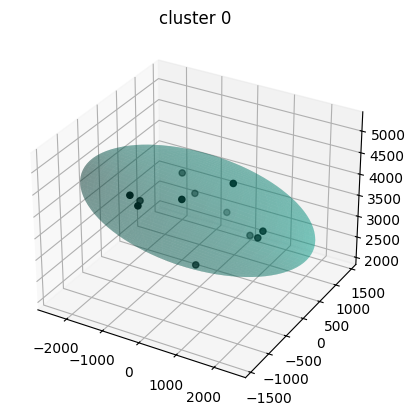

center of ellispe: [3.31262119e-01 5.16038482e-02 3.63420678e+03] 
axis: [2649.65560059 1608.40616665  987.29433784] 
azimuth [[-50.55387703 -26.94600912   1.01215619]
 [-16.96562797  33.4562909   43.3087799 ]
 [ 20.95899175 -37.91299964  37.49841961]]


In [9]:
import numpy as np
from scipy.stats import chi2

def fit_ellipsoid(points, confidence_level=0.95):
    """
    Trova l'ellissoide che meglio approssima una distribuzione di punti 3D.
    
    Parameters:
    points: numpy.ndarray di shape (n, 3) contenente le coordinate (x,y,z) dei punti
    confidence_level: livello di confidenza per la dimensione dell'ellissoide (default 0.95)
    
    Returns:
    center: centro dell'ellissoide (array 3D)
    radii: lunghezza dei semiassi dell'ellissoide
    rotation: matrice di rotazione dell'ellissoide
    """
    # Calcola il centro come media dei punti
    center = np.mean(points, axis=0)
    
    # Centra i punti sottraendo la media
    centered_points = points - center
    
    # Calcola la matrice di covarianza
    cov_matrix = np.cov(centered_points, rowvar=False)
    
    # Calcola autovalori e autovettori
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Ordina autovalori e autovettori in ordine decrescente
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calcola i semiassi dell'ellissoide
    # Usiamo chi-square per determinare la dimensione dell'ellissoide
    chi2_val = chi2.ppf(confidence_level, df=3)
    radii = np.sqrt(eigenvalues * chi2_val)
    
    return center, radii, eigenvectors

def generate_ellipsoid_mesh(center, radii, rotation, n_points=50):
    """
    Genera i punti per visualizzare l'ellissoide.
    
    Parameters:
    center: centro dell'ellissoide
    radii: lunghezza dei semiassi
    rotation: matrice di rotazione
    n_points: numero di punti per la mesh
    
    Returns:
    X, Y, Z: coordinate dei punti della superficie dell'ellissoide
    """
    u = np.linspace(0, 2 * np.pi, n_points)
    v = np.linspace(0, np.pi, n_points)
    
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones_like(u), np.cos(v))
    
    # Applica la rotazione
    for i in range(len(x)):
        for j in range(len(x)):
            point = np.array([x[i,j], y[i,j], z[i,j]])
            rotated_point = rotation.dot(point) + center
            x[i,j], y[i,j], z[i,j] = rotated_point
            
    return x, y, z

for i,key in enumerate(cls_color):
    points=np.zeros((len(x_cls[i]), 3))
    points[:,0]=np.array(x_cls[i]).flatten()
    points[:,1]=np.array(y_cls[i]).flatten()
    points[:,2]=np.array(depth_cls[i]).flatten()


    center, radii, eigenvectors= fit_ellipsoid(points,confidence_level=0.90)
    X,Y,Z= generate_ellipsoid_mesh(center,radii,eigenvectors)

    # Plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:,0], points[:,1], points[:,2], c='black', label='Punti')
    ax.plot_surface(X, Y, Z, alpha=0.3, color=cls_color[key][0])
    ax.set_title(f'cluster {key}')
    plt.show()
    print(f'center of ellispe: {center} \naxis: {radii} \nazimuth {eigenvectors * 180 / np.pi}')


main eigenvector -0.9665641884371122 -0.2564247835738715


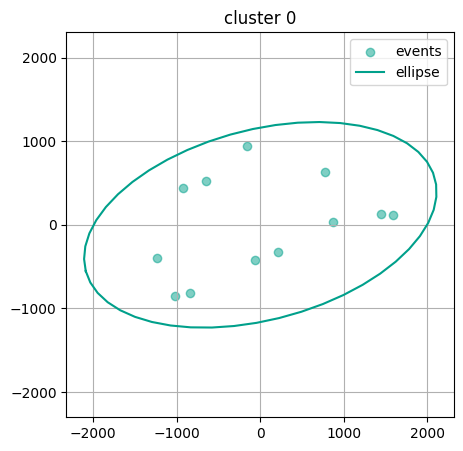

center of ellispe: [0.33126212 0.05160385] 
axis: [2161.07805385 1136.37323484] 
rotation -165.1419733187813 
GMT angle -104.85802668121873


In [10]:
import numpy as np
from scipy.stats import chi2

def fit_ellipse_2d(points, confidence_level=0.95):
    """
    Trova l'ellisse che meglio approssima una distribuzione di punti 2D.
    
    Parameters:
    points: numpy.ndarray di shape (n, 2) contenente le coordinate (x,y) dei punti
    confidence_level: livello di confidenza per la dimensione dell'ellisse (default 0.95)
    
    Returns:
    center: centro dell'ellisse (array 2D)
    radii: lunghezza dei semiassi dell'ellisse
    rotation: angolo di rotazione dell'ellisse in radianti
    """
    # Calcola il centro come media dei punti
    center = np.mean(points, axis=0)
    
    # Centra i punti sottraendo la media
    centered_points = points - center
    
    # Calcola la matrice di covarianza
    cov_matrix = np.cov(centered_points, rowvar=False)
    
    # Calcola autovalori e autovettori
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Ordina autovalori e autovettori in ordine decrescente
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    # Calcola i semiassi dell'ellisse
    chi2_val = chi2.ppf(confidence_level, df=2)
    radii = np.sqrt(eigenvalues * chi2_val)

    # Calcola l'angolo di rotazione dal primo autovettore
    rotation = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])       # arctan( y/x )
    x_main_axis=eigenvectors[0, 0]
    y_main_axis=eigenvectors[1, 0]
    print('main eigenvector',x_main_axis,y_main_axis)

    return center, radii, rotation , x_main_axis ,y_main_axis

def generate_ellipse_points(center, radii, rotation, n_points=50):
    """
    Genera i punti per disegnare l'ellisse.
    
    Parameters:
    center: centro dell'ellisse
    radii: lunghezza dei semiassi
    rotation: angolo di rotazione in radianti
    n_points: numero di punti per disegnare l'ellisse
    
    Returns:
    x, y: array delle coordinate x e y dei punti dell'ellisse
    """
    # Genera punti per un cerchio
    theta = np.linspace(0, 2*np.pi, n_points)
    
    # Crea l'ellisse
    x = radii[0] * np.cos(theta)
    y = radii[1] * np.sin(theta)
    
    # Crea la matrice di rotazione
    rot_matrix = np.array([
        [np.cos(rotation), -np.sin(rotation)],
        [np.sin(rotation), np.cos(rotation)]
    ])
    
    # Applica rotazione e traslazione
    points = np.dot(rot_matrix, np.array([x, y]))
    x = points[0, :] + center[0]
    y = points[1, :] + center[1]
    
    return x, y
ellipse_res=[]
for i,key in enumerate(cls_color):
    points=np.zeros((len(x_cls[i]), 2))
    points[:,0]=np.array(x_cls[i]).flatten()
    points[:,1]=np.array(y_cls[i]).flatten()

    center, radii, rotation ,x_main_axis ,y_main_axis = fit_ellipse_2d(points,confidence_level=0.90)    #VT : 0.90

    x_ellipse, y_ellipse = generate_ellipse_points(center, radii, rotation)

    plt.figure(figsize=(5, 5))
    plt.scatter(points[:,0], points[:,1], c=cls_color[key][0], alpha=0.5, label='events')
    plt.plot(x_ellipse, y_ellipse, cls_color[key][0], label='ellipse')
    plt.axis('equal')
    plt.grid(True)
    plt.legend()
    plt.title(f'cluster {key}')
    plt.show()

    rotation_angle= rotation * 180 / np.pi
    
    GMT_angle=np.arctan2(x_main_axis,y_main_axis) * 180 / np.pi

    ellipse_res.append( (center,radii,rotation_angle, GMT_angle) )

    print(f'center of ellispe: {center} \naxis: {radii} \nrotation {rotation_angle} \nGMT angle {GMT_angle}')

    

In [11]:
#DO ONE TIME TO CONVERT ANGLES
for i in range(len(ellipse_res)):
    print('angle before: ',ellipse_res[i][3])
    ellipse_res[i]=list(ellipse_res[i])

    if -180<=ellipse_res[i][3]<0:
        ellipse_res[i][3]+= 360
    elif 0<=ellipse_res[i][3]<=180:
        ellipse_res[i][3]+=0
    else:
        print('WARNING: check angles values')
    print('angle after:',ellipse_res[i][3])

#ellipse centre coordinates
new_cls_lat=[]
new_cls_lon=[]
for i in range(len(cls_lat_mean)):
    new_lat,new_lon = orthodrome.ne_to_latlon(cls_lat_mean[i],cls_lon_mean[i],ellipse_res[i][0][1],ellipse_res[i][0][0])
    new_cls_lat.append(new_lat)
    new_cls_lon.append(new_lon)

angle before:  -104.85802668121873
angle after: 255.14197331878125


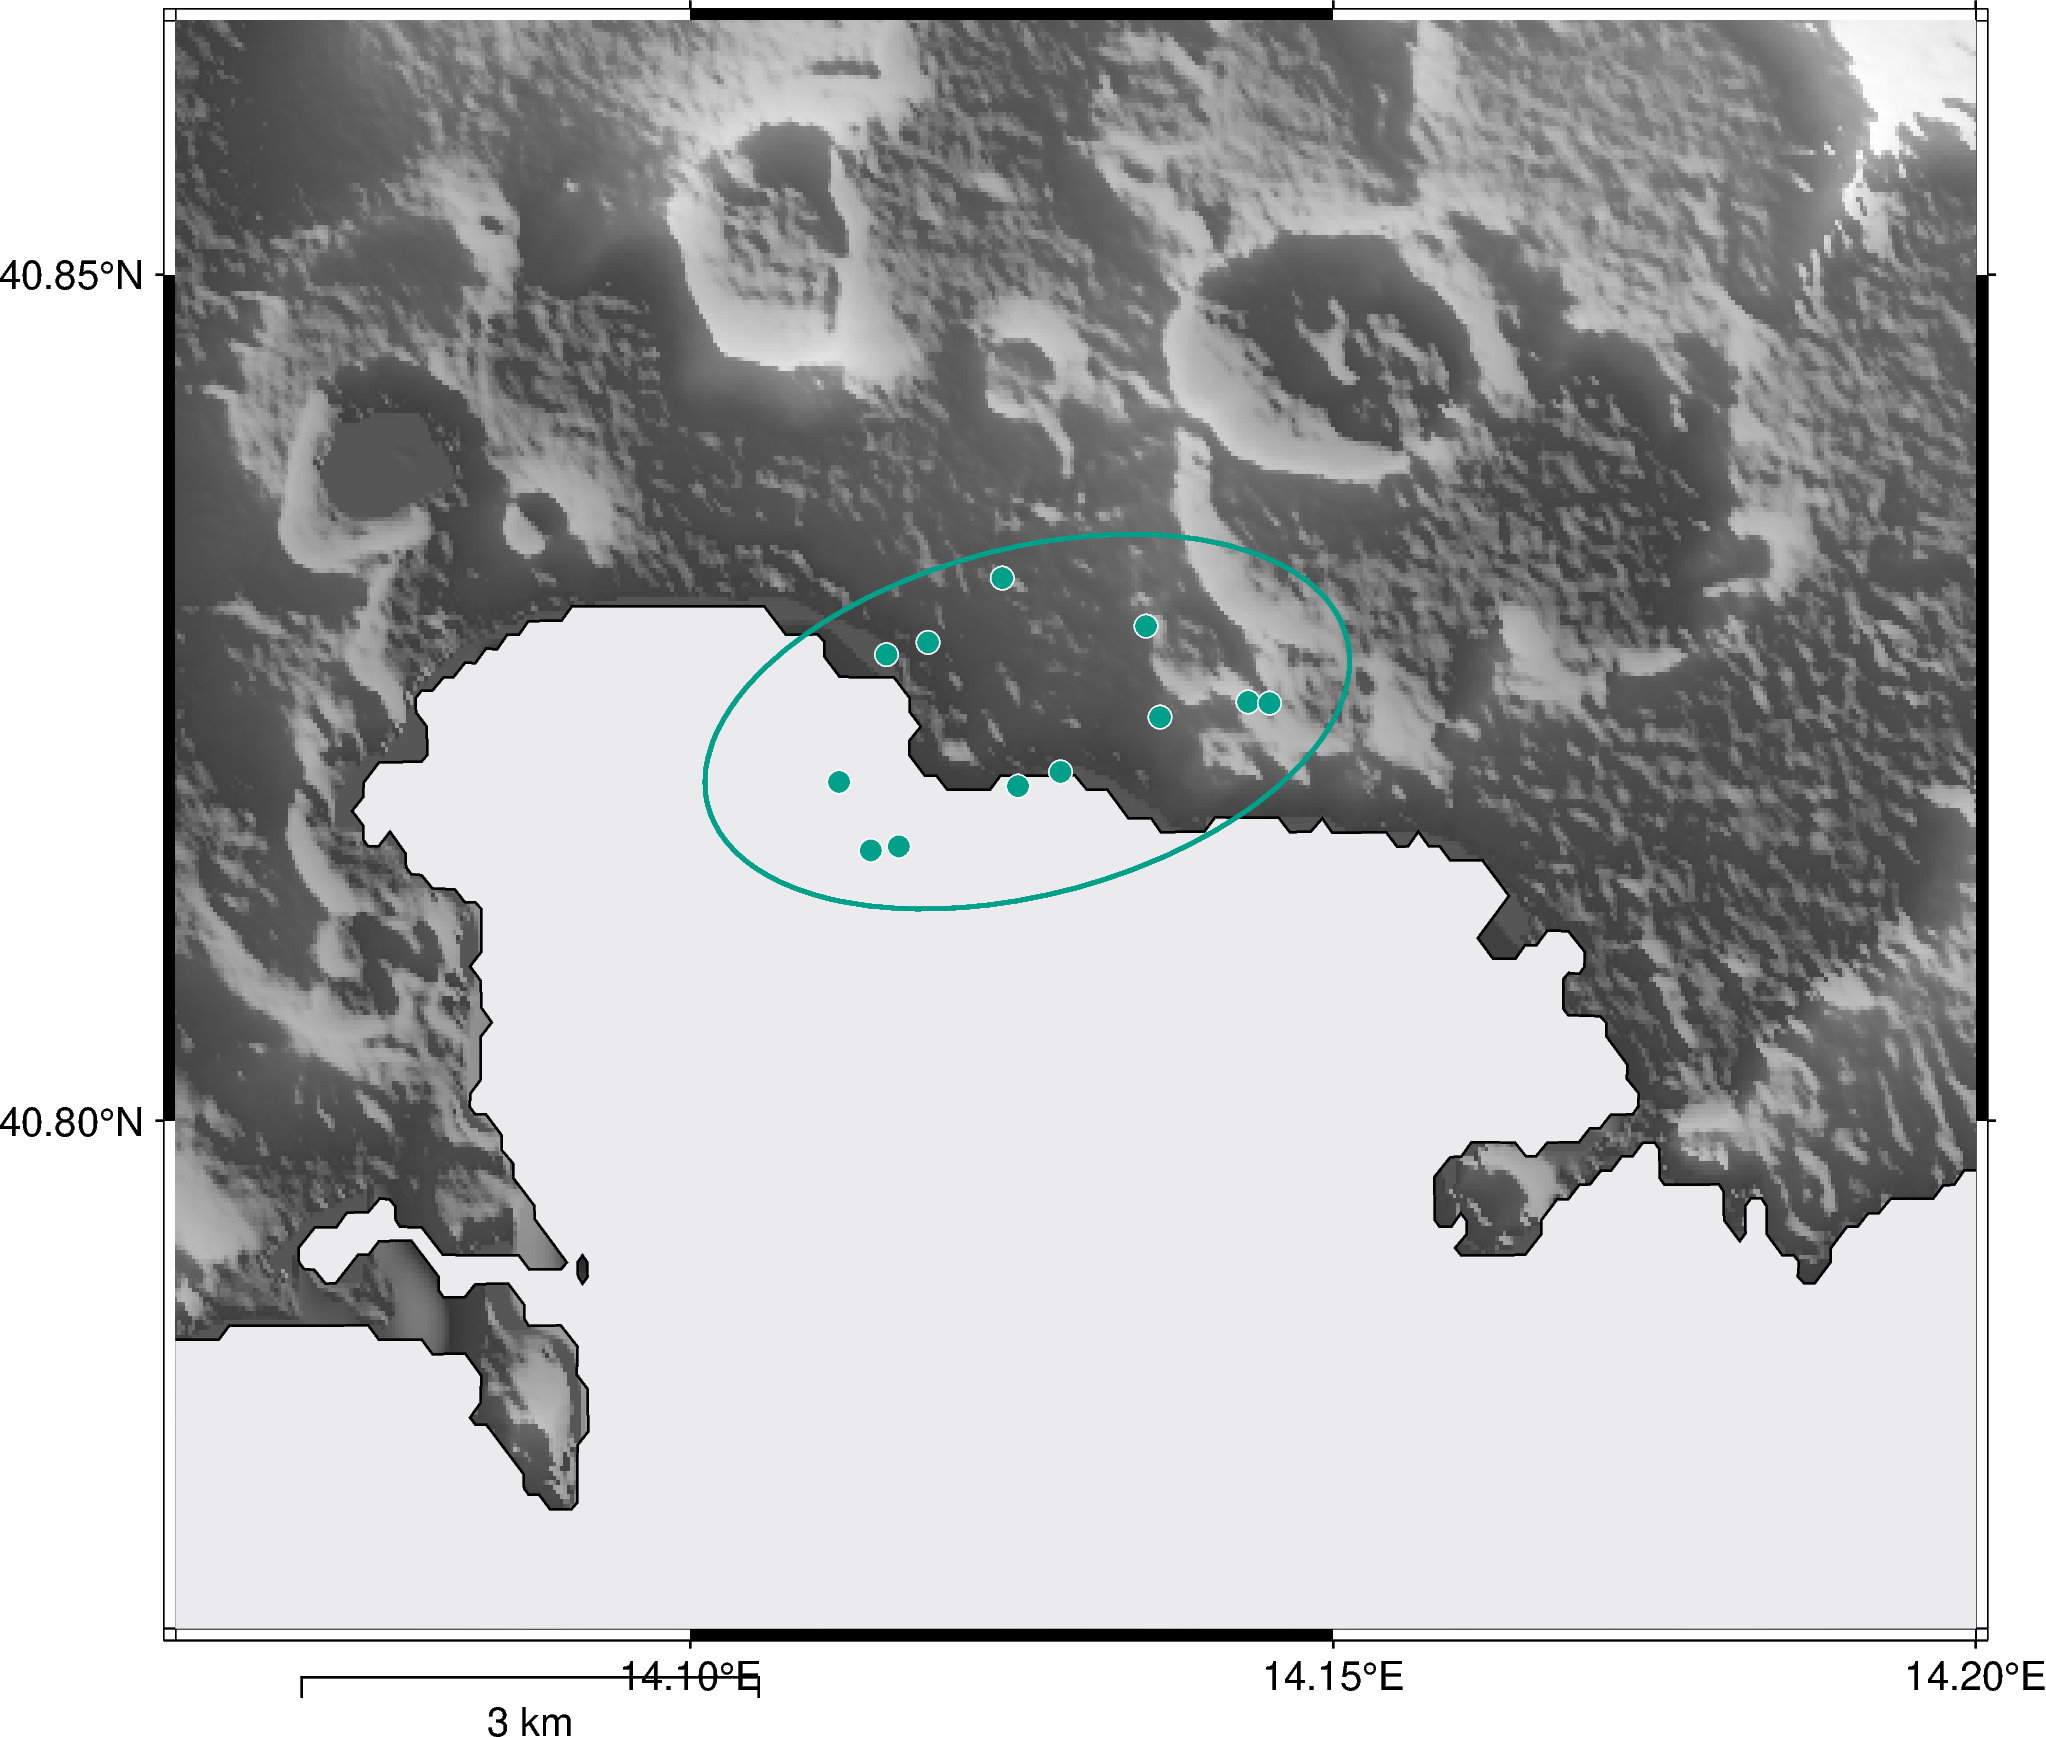

In [ ]:
switch_create_fig=False
#   CREATE FIGURE
minlon=14.06
maxlon=14.20
minlat=40.77
maxlat=40.865

fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.xxF")

# Define the region around the center coordinates (a smaller box for higher resolution)
region = [minlon, maxlon, minlat, maxlat]

# Define the projection
projection = "M6i"  # Mercator projection with a 6-inch width

fig.basemap(region=region,projection=projection, frame='a0.05', map_scale='x3c/-0.5c+w3k+lkm')
# Load high-resolution topography data (1 arc-second resolution)
topo_data = pygmt.datasets.load_earth_relief(resolution="01s", region=region)

# Plot the topography with shading
fig.grdimage(grid=topo_data, region=region, projection=projection, shading="+a45+ne0.5", cmap="gray")
# Plot coastlines with high resolution
fig.coast(shorelines="1/0.5p,black", resolution="f", water="#EBEBEE")

#fig.plot(x=new_cls_lon[:], y=new_cls_lat[:], style="c0.2c", fill="#BD2025", pen="#BD2025", label='centre cluster') # red filling
for i,key in enumerate(cls):
    fig.plot(x=cls_lon_all[i][:], y=cls_lat_all[i][:], style="c0.2c",fill=cls_color[key][0],  pen="white")

ellipses_txt=[]
for i,key in enumerate(cls):
    fig.plot(
        x=[new_cls_lon[i]],
        y=[new_cls_lat[i]],
        pen=f"1p,{cls_color[key][0]}",
        style = f'E{ellipse_res[i][3]}/{ellipse_res[i][1][0]*0.002}/{ellipse_res[i][1][1]*0.002}'       # x0.001 to convert m in KM
                                                                                                        # x2 because of semiaxis conversion
        #style= 'E10/3/0.5'
        )
    ellipses_txt.append(str(cls_color[key][0])+','+str(new_cls_lat[i])+','+str(new_cls_lon[i])+','+str(ellipse_res[i][1][0]*0.001)
                        +','+str(ellipse_res[i][1][1]*0.001)+','+str(ellipse_res[i][3]))
fig.show()
if switch_create_fig:
    if switch_VT:
        fig.savefig('../PLOTS/MAPS_ELLIPSES/ellipses_VT.pdf')
    else:
        fig.savefig('../PLOTS/MAPS_ELLIPSES/ellipses_VLP.pdf')

In [14]:
switch_create_txt_catalogue_clusters=True

if switch_create_txt_catalogue_clusters:
    workdir='../'
    catdir=os.path.join(workdir,'CAT')
    catdir=os.path.join(catdir,'ellipses_txt')

    if switch_VT:
        filename_cat=os.path.join(catdir,'cat_cluster_')
    else:
        filename_cat=os.path.join(catdir,'cat_VLP_cluster_')

    for key in cls:
        events_txt=[]
        for ev in cls[key]:
            name=ev.name
            lat= str(ev.lat)
            lon=str(ev.lon)
            depth=str(-ev.depth)
            events_txt.append(name+','+lat+','+lon+','+depth)
        
        with open(filename_cat + str(key) + '.txt', 'w') as output:
            output.write('name,lat,lon,depth\n')
            for row in events_txt:
                output.write(str(row) + '\n')

In [15]:
switch_create_txt_ellipses=True

if switch_create_txt_ellipses:

    if switch_VT:
        workdir='../'
        catdir=os.path.join(workdir,'CAT')
        catdir=os.path.join(catdir,'ellipses_txt')

        for i,key in enumerate(cls):
            filename='ellipse_cluster'+str(key)               #CHANGE
            catname=os.path.join(catdir,filename+'.txt')
            with open(catname, 'w') as output:
                output.write('name_color,lat,lon,major_axis,minor_axis,azimuth\n')  
                output.write(str(ellipses_txt[i]))

    else:
        workdir='../'
        catdir=os.path.join(workdir,'CAT')
        catdir=os.path.join(catdir,'ellipses_txt')


        filename='ellipse_cluster_VLP'               #CHANGE
        catname=os.path.join(catdir,filename+'.txt')
        with open(catname, 'w') as output:
            output.write('name_color,lat,lon,major_axis,minor_axis,azimuth\n')  
            output.write(str(ellipses_txt[0]))

# MT figure

In [36]:
#include events not in cluster
switch_all_cls=True
if switch_all_cls:
    cluster_number=[]
    cluster_color=[]
    for ev in clusty_events:
        if not ev.extras['cluster_number'] in cluster_number:
            cluster_number.append(ev.extras['cluster_number'])
            cluster_color.append(ev)
    
    cls = {key: [] for key in cluster_number}
    for ev in clusty_events:
        cls[ev.extras['cluster_number']].append(ev)
    
    cls_color = {key: [] for key in cluster_number}
    for color in cluster_color:
        if color.extras['cluster_number'] == -1:
            cls_color[color.extras['cluster_number']].append('#5D5D5D')
        else:
            cls_color[color.extras['cluster_number']].append(color.extras['color'])

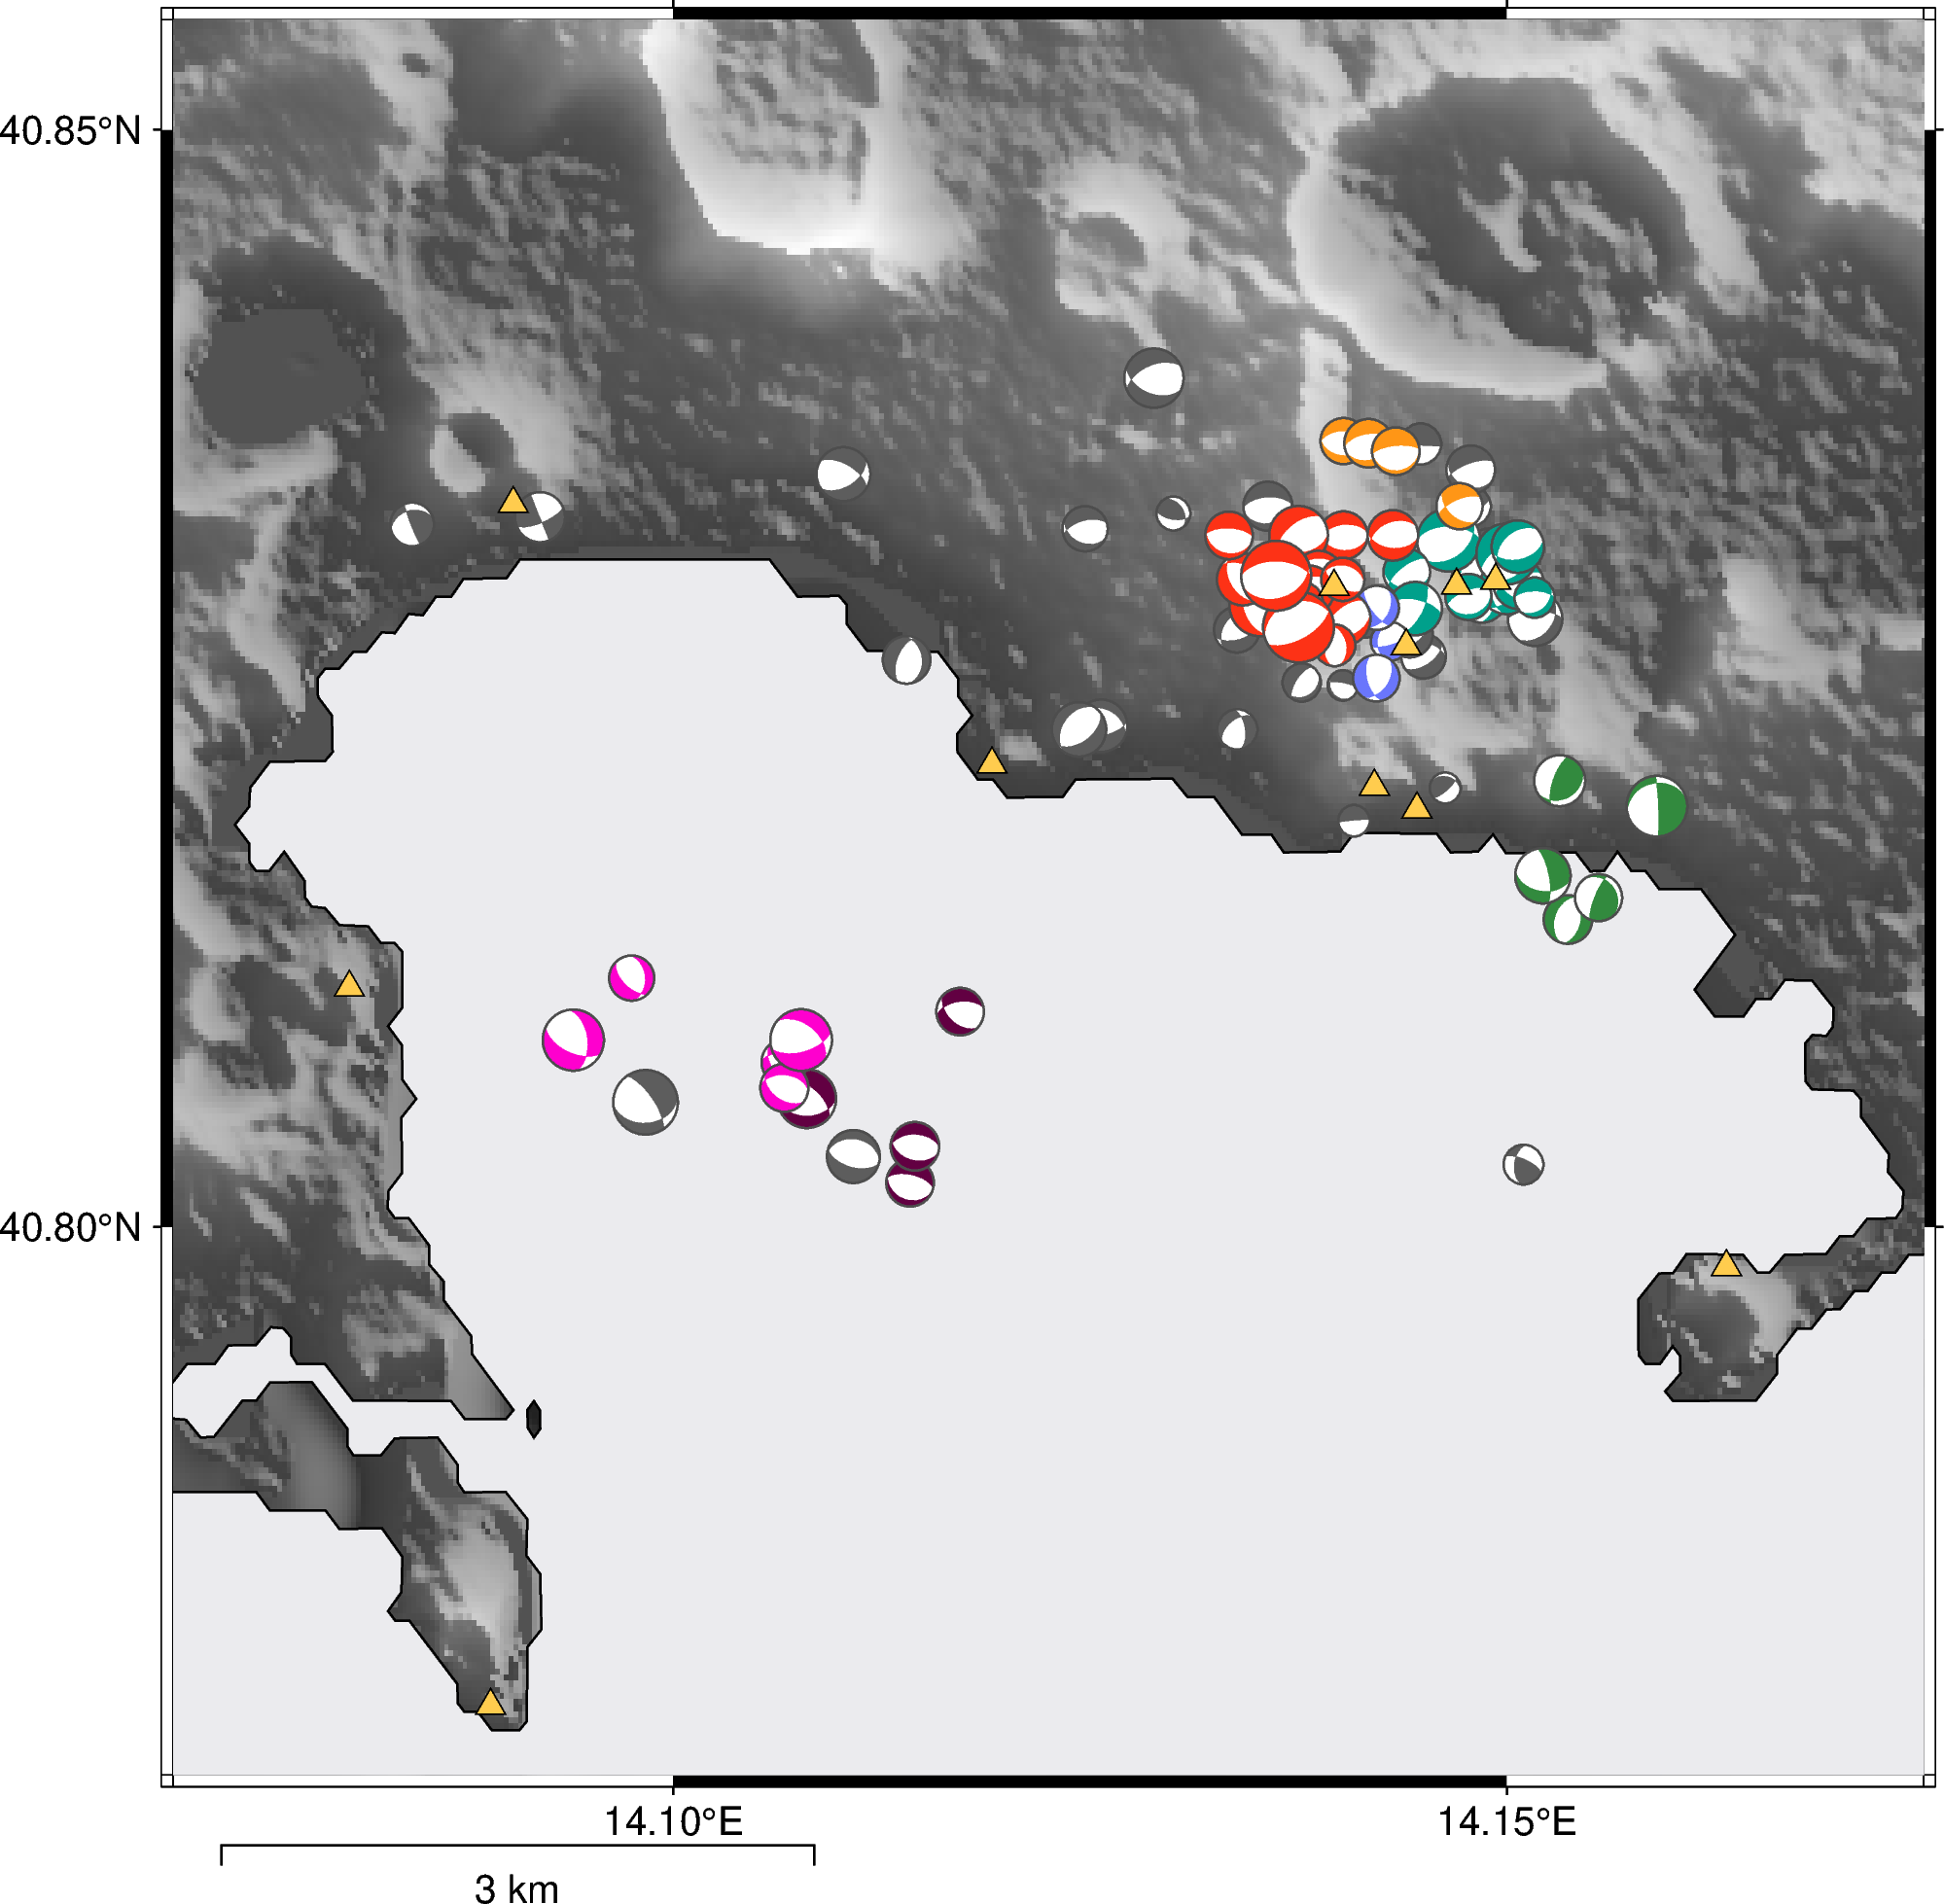

In [ ]:
workdir='../'
metadatadir =  os.path.join(workdir,'META_DATA')

if switch_VT:
    filename='catalogue_flegrei_MT_final'
else:
    filename='catalogue_flegrei_MT_final_VLP_reloc'
# COORDINATES 
minlon=14.07
maxlon=14.175
minlat=40.775
maxlat=40.855

#   CREATE FIGURE
fig = pygmt.Figure()
pygmt.config(FORMAT_GEO_MAP="ddd.xxF")
# Define the region around the center coordinates (a smaller box for higher resolution)
region = [minlon, maxlon, minlat, maxlat]
# Define the projection
projection = "M6i"  # Mercator projection with a 6-inch width
fig.basemap(region=region,projection=projection, frame='a0.05', map_scale='x3c/-0.7c+w3')
# Load high-resolution topography data (1 arc-second resolution)
topo_data = pygmt.datasets.load_earth_relief(resolution="01s", region=region)
# Plot the topography with shading
fig.grdimage(grid=topo_data, region=region, projection=projection, shading="+a45+ne0.5", cmap="gray")
# Plot coastlines with high resolution
fig.coast(shorelines="1/0.5p,black", resolution="f", water="#EBEBEE")

# TRUE if you want to plot deviatoric MT. FALSE for DC
##########################################
############## SWITCH ##############
##########################################
switch_deviatoric=False                                                                                                                                                                                            

# loop on events in catalogue and plot FM
for ev in cls[-1]:
    if switch_deviatoric:
        msix = pmt.to6(ev.moment_tensor.m_up_south_east())
        moment_tensor_par = {
            "mrr": msix[0]* 10**7,         # Radial-Radial
            "mtt": msix[1]* 10**7,         # Tangential-Tangential
            "mff": msix[2]* 10**7,         # Perpendicular-Perpendicular
            "mrt": msix[3]* 10**7,         # Radial-Tangential
            "mrf": msix[4]* 10**7,         # Radial-Perpendicular
            "mtf": msix[5]* 10**7,         # Tangential-Perpendicular
            "exponent": 1                  # np.log10(mm) !!!WRONG!!!
            }
        MT_white=True
        if MT_white:
            fig.meca(spec=moment_tensor_par,convention='mt', longitude =ev.lon, latitude=ev.lat, depth=ev.depth,
                    scale="1.7c", compressionfill="white",extensionfill="white", pen="1p,black",outline="2p,black")
        else:
            fig.meca(spec=moment_tensor_par,convention='mt', longitude =ev.lon, latitude=ev.lat, depth=ev.depth,
                    scale="0.8c", compressionfill='#5D5D5D',extensionfill="white", pen="0.5p,gray30,solid") 
    else:
        moment_tensor_par = {
            "strike": ev.moment_tensor.strike1,
            "dip": ev.moment_tensor.dip1,
            "rake": ev.moment_tensor.rake1,
            "magnitude": ev.magnitude 
            }
        fig.meca(spec=moment_tensor_par, longitude =ev.lon, latitude=ev.lat, depth=ev.depth,
                    scale="0.8c", compressionfill='#5D5D5D',extensionfill="white", pen="0.5p,gray30,solid") 
                    # blue : #0066cc        red :  #BD2025

for i,key in enumerate(cls):
    if key != -1:
        for ev in cls[key]:
            if switch_deviatoric:

                msix = pmt.to6(ev.moment_tensor.m_up_south_east())
                moment_tensor_par = {
                    "mrr": msix[0]* 10**7,         # Radial-Radial
                    "mtt": msix[1]* 10**7,         # Tangential-Tangential
                    "mff": msix[2]* 10**7,         # Perpendicular-Perpendicular
                    "mrt": msix[3]* 10**7,         # Radial-Tangential
                    "mrf": msix[4]* 10**7,         # Radial-Perpendicular
                    "mtf": msix[5]* 10**7,         # Tangential-Perpendicular
                    "exponent": 1                  # np.log10(mm) !!!WRONG!!!
                    }

                MT_white=True
                if MT_white:
                    fig.meca(spec=moment_tensor_par,convention='mt', longitude =ev.lon, latitude=ev.lat, depth=ev.depth,
                            scale="1.7c", compressionfill="white",extensionfill="white", pen="1p,black",outline="2p,black")
                else:
                    fig.meca(spec=moment_tensor_par,convention='mt', longitude =ev.lon, latitude=ev.lat, depth=ev.depth,
                            scale="0.8c", compressionfill=cls_color[key][0],extensionfill="white", pen="0.5p,gray30,solid") 
            else:
                moment_tensor_par = {
                    "strike": ev.moment_tensor.strike1,
                    "dip": ev.moment_tensor.dip1,
                    "rake": ev.moment_tensor.rake1,
                    "magnitude": ev.magnitude 
                    }

                fig.meca(spec=moment_tensor_par, longitude =ev.lon, latitude=ev.lat, depth=ev.depth,
                            scale="0.8c", compressionfill=cls_color[key][0],extensionfill="white", pen="0.5p,gray30,solid") 
                            # blue : #0066cc        red :  #BD2025

#   STATIONS
f=open(metadatadir + '/stations_flegrei_INGV_final.pf','r')
latsta=[]
lonsta=[]
namsta=[]
for line in f:
    toks=line.split()
    latsta.append(eval(toks[1]))
    lonsta.append(eval(toks[2]))
    namsta.append(toks[0].split('.')[1])
latsta=np.array(latsta)
lonsta=np.array(lonsta)

# Plot stations
fig.plot(x=lonsta, y=latsta, style="t0.3", fill="#FFCC4E", pen="black") # yelow filling
#fig.text(x=lonsta+0.005, y=latsta+0.002, text=namsta, justify='BR',font='5p',fill="#FFCC4E")

fig.show()

switch_create_fig_2=False
if switch_create_fig_2:
    if switch_deviatoric:
        fig.savefig(workdir + 'PLOTS/MAPS/'+filename + '_deviatoric_clusty'  + '.pdf')
    else:
        fig.savefig(workdir + 'PLOTS/MAPS/'+filename + '_dc_clusty' + '.pdf')
